In [1]:
import functools
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt

In [2]:
np.random.seed(123459876)

In [3]:
b0_min, b0_max = -10, +10
b1_min, b1_max = -10, +10

In [4]:
def real_model(t, b0, b1):
    return np.exp(-b0*(t-b1))
    #return np.sin(6*b0*t) + b1
    #return b1*t + b0

In [5]:
def test_model(t, b0, b1):
    return real_model(t, b0, b1)
    #return np.sqrt(np.abs(b0 - t)) + b1*np.power(t, 3)
    #return np.sin(6*b0*t) + b1
    #return b1*t + b0

In [6]:
pb0 = 1
pb1 = 1
sigma = 0.025
N = 100

In [7]:
t = np.linspace(0, 1, N)
x = real_model(t, pb0, pb1)
e = np.random.randn(t.size)
xn = x + sigma*e

In [8]:
popt_r, pcov_r = optimize.curve_fit(real_model, t, xn,)# [-7.5, -7.5], maxfev=10000)
popt_t, pcov_t = optimize.curve_fit(test_model, t, xn,)# [-5.0, -5.0], maxfev=10000)

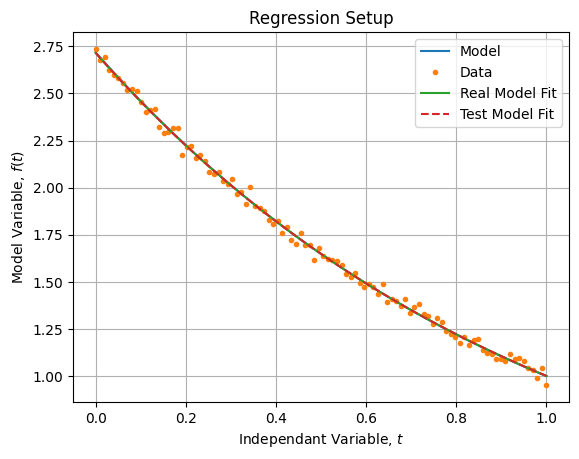

In [9]:
fig, axe = plt.subplots()
axe.plot(t, x, label="Model")
axe.plot(t, xn, linestyle="None", marker=".", label="Data")
axe.plot(t, real_model(t, *popt_r), label="Real Model Fit")
axe.plot(t, test_model(t, *popt_t), linestyle="--", label="Test Model Fit")
axe.set_title("Regression Setup")
axe.set_xlabel("Independant Variable, $t$")
axe.set_ylabel("Model Variable, $f(t)$")
axe.grid()
axe.legend()

In [10]:
b0 = np.linspace(b0_min, b0_max, 300)
b1 = np.linspace(b1_min, b1_max, 300)
B0, B1 = np.meshgrid(b0, b1)

In [11]:
def _objective(f, x, t, b0, b1):
    return np.log(np.sum(np.power(f(t, b0, b1) - x, 2))/t.size)
objective = np.vectorize(_objective, excluded=["f", "t", "x"])

In [12]:
MLE = objective(test_model, t=t, x=xn, b0=B0, b1=B1)

In [13]:
MLE.min(), MLE.max()

(-6.775418790993639, 217.09352756113773)

In [14]:
goal = functools.partial(_objective, test_model, xn, t)

In [15]:
def objective_(beta, f, t, x):
    return np.log(np.sum(np.power(f(t, beta[0], beta[1]) - x, 2)))/t.size

In [16]:
b0_ = np.linspace(-5, 5, 5)
b1_ = np.linspace(-5, 5, 5)
B0_, B1_ = np.meshgrid(b0_, b1_)

In [17]:
B = np.stack([
    B0_.flatten(),
    B1_.flatten(),
]).T
B = np.array([
    #[3, 3],
    [-7.5, +7.5],
    [-7.5, -7.5],
    [0, 0],
    [1, 1],
    [+7.5, -7.5],
    [+7.5, +7.5],
])

In [18]:
def callback(pk):
    global trace
    trace.append(pk)
    return False

In [19]:
traces = []
results = []
for params in B:
    trace = [params]
    result = optimize.minimize(objective_, params, args=(test_model, t, xn), callback=callback)
    traces.append(np.array(trace))
    results.append(result)

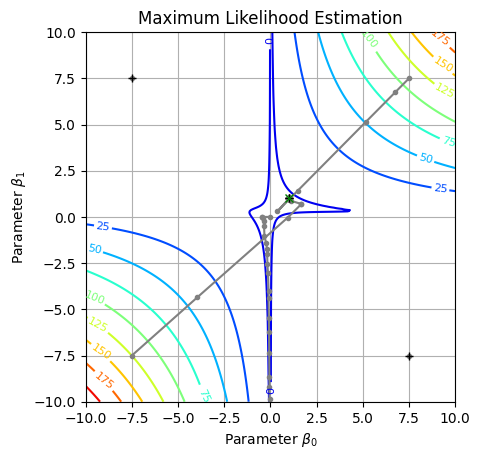

In [20]:
fig, axe = plt.subplots()
c = axe.contour(B0, B1, MLE, 10, cmap="jet")
axe.clabel(c, c.levels, inline=True, fontsize=8)
for result, trace in zip(results, traces):
    axe.plot(*trace.T, linestyle="-", marker=".", color="gray")
    axe.plot(*result.x, marker="+", color="black")
axe.plot(pb0, pb1, marker="x", color="green")
axe.set_title("Maximum Likelihood Estimation")
axe.set_xlabel(r"Parameter $\beta_0$")
axe.set_ylabel(r"Parameter $\beta_1$")
axe.set_xlim([b0_min, b0_max])
axe.set_ylim([b1_min, b1_max])
axe.set_aspect("equal")
axe.grid()